In [1]:
import pandas as pd
import sklearn as sk

In [2]:
df = pd.read_csv(r'C:/Users/user/Documents/Edu/hw11_text_classification/IMDB Dataset.csv', sep=',')

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no pun


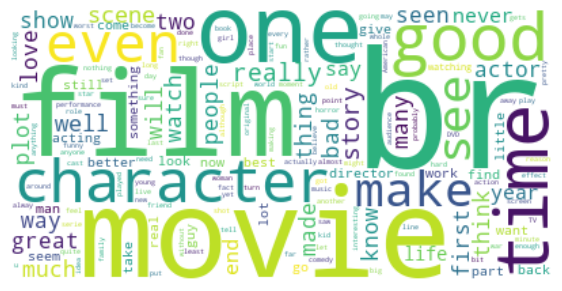

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(df['review'])
print(text[:380])
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
import re

In [8]:
def preprocess_text(text):
    text = re.sub(r'movie', '', text)
    text = re.sub(r'film', '', text)
    text = re.sub(r'one', '', text)
    text = re.sub(r'time', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\w\s\.]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [9]:
df['cl_review'] = df['review'].apply(preprocess_text)

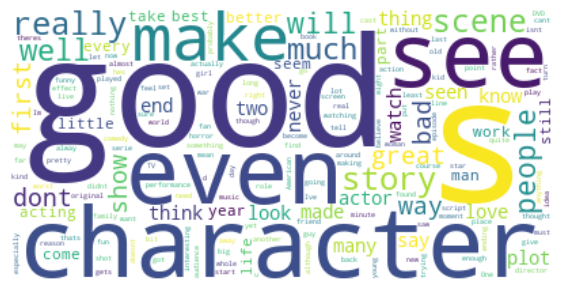

In [10]:
text = ' '.join(df['cl_review'])
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
for i in range(2):
    print(i + 1, ':')
    print('Original text:',df['review'][i])
    print('->')
    print('Clean text:',df['cl_review'][i])
    print('>>>')

1 :
Original text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the sho

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df['cl_review'], df['sentiment'], test_size=0.3, random_state=17)

In [15]:
vc = CountVectorizer(binary=False, analyzer='word', ngram_range=(1, 3))
x = vc.fit(df['cl_review'])
vc.get_feature_names_out()

array(['00', '00 01', '00 01 percent', ..., 'כרמון', 'כרמון is',
       'כרמון is the'], dtype=object)

In [16]:
f_train = vc.fit_transform(x_train)
f_test = vc.transform(x_test)
print(f_train.shape, f_test.shape)

(35000, 6858706) (15000, 6858706)


In [17]:
train_labels = [1 if sentiment=='positive' else 0 for sentiment in y_train]
test_labels = [1 if sentiment=='positive' else 0 for sentiment in y_test]

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
clf = LogisticRegression(max_iter=2000)
clf.fit(f_train, train_labels)
predictions = clf.predict(f_test)
print(classification_report(test_labels, predictions, target_names=['Neg','Pos']))
print(confusion_matrix(test_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

         Neg       0.91      0.90      0.91      7438
         Pos       0.91      0.92      0.91      7562

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000

[[6719  719]
 [ 637 6925]]


In [19]:
import spacy

In [22]:
nlp = spacy.blank("en")
nlp.pipe_names

[]

In [25]:
if 'textcat' not in nlp.pipe_names:
    nlp.add_pipe("textcat", last=True)
nlp.pipe_names

['textcat']

In [26]:
textcat = nlp.get_pipe("textcat")
categories = ['positive', 'negative']
for category in categories:
    textcat.add_label(category)

In [46]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=17)

In [67]:
train_texts = train_data['cl_review'].values
train_labels = train_data['sentiment'].values

In [68]:
test_texts = test_data['cl_review'].values
test_labels = test_data['sentiment'].values

In [69]:
from spacy.training.example import Example
train_examples = []
for text, label in zip(train_texts, train_labels):
    example = Example.from_dict(nlp.make_doc(text), {"cats": {label: 1.0}})
    train_examples.append(example)

In [77]:
n_epochs = 10
batch_size = 8
learn_rate = 0.001

In [82]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):
    #optimizer = nlp.create_optimizer()
    optimizer = nlp.initialize()
    optimizer.learn_rate = learn_rate

In [80]:
from spacy.util import minibatch, compounding
print("Training the model...")
for epoch in range(n_epochs):
    random.shuffle(train_examples)
    losses = {}
    batches = minibatch(train_examples, size=batch_size)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)
    print(f"Epoch {epoch+1} - Loss: {losses['textcat']:.4f}")

Training the model...
Epoch 1 - Loss: 485.2735
Epoch 2 - Loss: 320.4151
Epoch 3 - Loss: 247.2593
Epoch 4 - Loss: 198.7870
Epoch 5 - Loss: 157.6717
Epoch 6 - Loss: 131.1662
Epoch 7 - Loss: 111.9320
Epoch 8 - Loss: 96.7834
Epoch 9 - Loss: 81.5723
Epoch 10 - Loss: 74.9854


In [81]:
correct = 0
total = 0
for text, true_label in zip(test_texts, test_labels):
    doc = nlp(text)
    predicted_label = max(doc.cats, key=doc.cats.get)
    if predicted_label == true_label:
        correct += 1
    total += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8829
